In [599]:
%load_ext autoreload
%autoreload 2
     
import torch
import os
from matplotlib import pyplot as plt
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders
from math import prod
from torchvision import transforms

import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset


print(torch.cuda.is_available())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


In [600]:

device = os.environ["DEVICE"]
DATA_PATH = os.environ['DATA_PATH']
CACHE_DIR = os.path.join(DATA_PATH, 'brainreader_cache')
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, 'brainreader')

BATCH_SIZE = 64
EPOCHS = 30
WEIGHT_DECAY=0e-4
LEARNING_RATE = .0002* BATCH_SIZE
READIN_DTYPE = torch.bfloat16
RESNET_DECODE_MODEL = '/scratch/izar/vanousek/cs-433-project/models/mlp2489100.pt'

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [601]:
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "encoder_ball_50.pt"),
    # "load_ckpt": os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    "train": True,
}
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": BATCH_SIZE,
    # "sessions": list(range(1, 23)),
    "sessions": [1],
    "resize_stim_to": (224, 224),
    "normalize_stim": False,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": True,
    "additional_keys": None,
    "avg_test_resp": True,
}

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
print(len(dl['train']), len(dl['test']))

71 2


1
torch.Size([64, 1, 224, 224])
torch.Size([64, 9395])
1


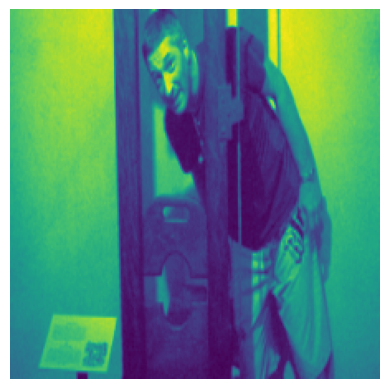

In [602]:
def show_image(img_tensor, title=''):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

items = next(dl['train'])
print(len(items))
item = items[0]
stim = item['stim']
print(stim.shape)

resp = item['resp']
print(resp.shape)
neurons = resp.shape[1]
data_key = item['data_key']
print(data_key)
# plot the stim as grayscale image with matplotlib
show_image(stim[0]) 


In [603]:


import torch
device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

class ResnetExtractor:
    def __init__(self):
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]

    def get_features(self, img, verbose = False):
        IMGNET_NORM = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        # imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).nsqueeze(0)

        def assign_features(module, input, output):
            nonlocal features
            features = output
        hook = self.resnet_layer.register_forward_hook(assign_features)
        
        with torch.no_grad():
            raw_output = self.resnet50(img)
            if verbose:
                output = torch.nn.functional.softmax(raw_output, dim=1)
                results = utils.pick_n_best(predictions=output, n=5)
                for i, result in enumerate(results):
                    show_image(img[i], result)



        hook.remove()
        assert features is not None
        features = features.squeeze(0)
        return features

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [604]:
import torch
from torch.nn import functional as F
from math import prod

class RidgeRegressor(torch.nn.Module):
    def __init__(self, n_features, target_shape, alpha=1.0, device='cpu', dtype=torch.float32):
        super().__init__()
        self.alpha = alpha
        self.target_shape = target_shape
        self.inter_shape = (128, 14, 14)

        self.model = torch.nn.Sequential(
            # Linear layer to map input to intermediate feature space
            torch.nn.Linear(n_features, prod(self.inter_shape), bias=True, device=device, dtype=dtype),
            torch.nn.LeakyReLU(0.1, inplace=True),

            # Reshape to intermediate shape
            torch.nn.Unflatten(1, self.inter_shape),

            # Conv1: 128 -> 256 with BatchNorm and ReLU
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2, bias=True),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.1, inplace=True),

            # Conv2: 256 -> 512 with BatchNorm and ReLU
            torch.nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2, bias=True),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.1, inplace=True),

            torch.nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, bias=True),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.1, inplace=True),

            torch.nn.Conv2d(512, 1024, kernel_size=1, stride=1, padding=0, bias=True),
            torch.nn.BatchNorm2d(1024),
            # torch.nn.LeakyReLU(0.1, inplace=True),
        )
        
    def forward(self, x):
        return self.model(x)
def initialize_weights(module):
    if isinstance(module, torch.nn.Linear):
        # Initialize weights close to zero
        torch.nn.init.uniform_(module.weight, a=-0.000001, b=0.000001)
        if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0.0)

    elif isinstance(module, torch.nn.Conv2d):
        # Initialize weights close to zero
        torch.nn.init.uniform_(module.weight, a=-0.000001, b=0.000001)
        if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0.0)

    elif isinstance(module, torch.nn.BatchNorm2d):
        # BatchNorm weight and bias initialization
        torch.nn.init.constant_(module.weight, 1.0)
        torch.nn.init.constant_(module.bias, 0.0)
readin.apply(initialize_weights)



readin = RidgeRegressor(neurons, (1024, 14, 14))
readin.to(device, dtype=READIN_DTYPE)
    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(readin)
print("Total parametrs: ", params)

Total parametrs:  240616448


In [605]:

optimizer = torch.optim.Adam(readin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dl['train'])*EPOCHS, eta_min=LEARNING_RATE/5)

extractor = ResnetExtractor()

losses = []


for epoch in range(EPOCHS):
    dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
    for minibatch in tqdm(dl['train']):
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)

        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        
        with torch.cuda.amp.autocast():
            pass
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)
        output = readin(resp)
        loss = criterion(output, target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(readin.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)
        losses.append(relative_loss)
        # print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")

        optimizer.zero_grad()
    print(f"Epoch {epoch} finished with relative loss {np.mean(losses[-len(dl['train']):])}")



Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
  0%|                                                                                        | 0/71 [00:00<?, ?it/s]/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 0 finished with relative loss 3.7878859759700205


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 1 finished with relative loss 0.3642104389483819


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 2 finished with relative loss 0.22334965176336433


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:22<00:00,  3.22it/s]


Epoch 3 finished with relative loss 0.21452806282214573


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 4 finished with relative loss 0.20954002301077448


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 5 finished with relative loss 0.2043227746586931


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 6 finished with relative loss 0.1996153018968591


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 7 finished with relative loss 0.19501141952305406


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 8 finished with relative loss 0.19002832727788582


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 9 finished with relative loss 0.18528662018640835


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 10 finished with relative loss 0.18063608270783607


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 11 finished with relative loss 0.17583488847985088


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 12 finished with relative loss 0.1711683638148938


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 13 finished with relative loss 0.16634489020729312


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 14 finished with relative loss 0.1616261664941035


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.23it/s]


Epoch 15 finished with relative loss 0.15742196773356565


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 16 finished with relative loss 0.1533773236516288


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 17 finished with relative loss 0.1495050180753833


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 18 finished with relative loss 0.14632592934658148


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 19 finished with relative loss 0.14331117321414644


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 20 finished with relative loss 0.13999637724794475


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 21 finished with relative loss 0.13761179129800602


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 22 finished with relative loss 0.13526991356731846


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 23 finished with relative loss 0.13339054913890452


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 24 finished with relative loss 0.13163920270044158


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 25 finished with relative loss 0.130233845250391


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 26 finished with relative loss 0.1291719743172013


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.24it/s]


Epoch 27 finished with relative loss 0.12746438179300576


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 28 finished with relative loss 0.12698791360711756


100%|███████████████████████████████████████████████████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]

Epoch 29 finished with relative loss 0.12607135458456664


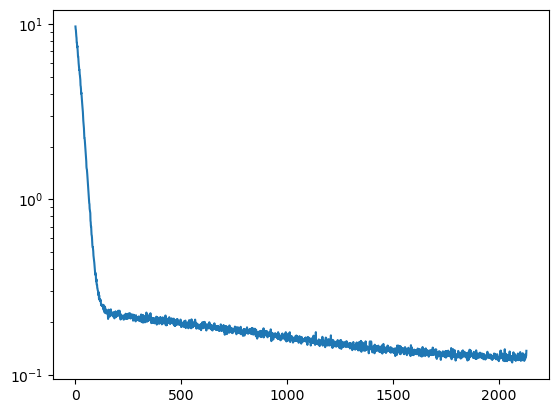

In [606]:
# Plot losses
plt.plot(losses)
plt.yscale('log')


In [607]:
# Evaluate the model
readin.eval()
test_losses = []
imgnet_activations_real = []
imgnet_activations_pred = []

with torch.no_grad():
    for minibatch in dl['test']:
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)
        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

        output = readin(resp)

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)

        test_losses.append(relative_loss)
        imgnet_activations_real.append(target)
        imgnet_activations_pred.append(output)

        print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")
        print(f"Loss: {loss.item()}")
# .22
print(f"Mean loss: {np.mean(test_losses)}")
print(f"Std loss: {np.std(test_losses)}")

Loss: 0.0157470703125 Constant loss: 0.1162109375 Relative loss: 0.1355030356713569
Loss: 0.0157470703125
Loss: 0.0157470703125 Constant loss: 0.1181640625 Relative loss: 0.13326333502764406
Loss: 0.0157470703125
Mean loss: 0.1343831853495005
Std loss: 0.001119850321856422


/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 36, 1024, 14, 14])) that is different to the input size (torch.Size([36, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 224, 224])


<Figure size 640x480 with 0 Axes>

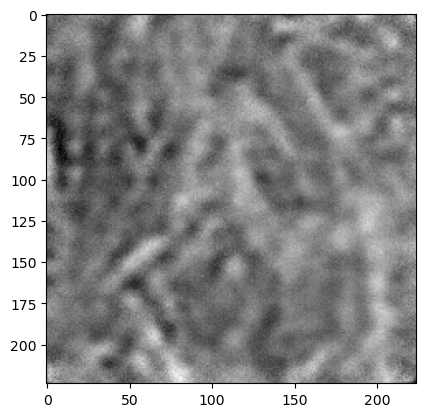

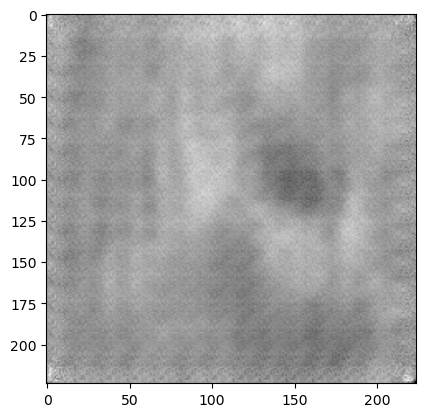

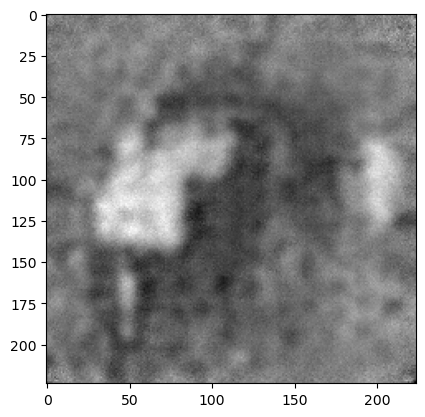

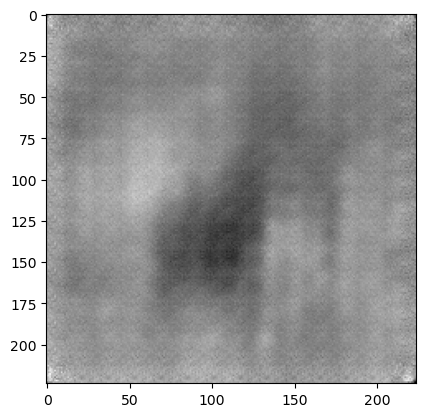

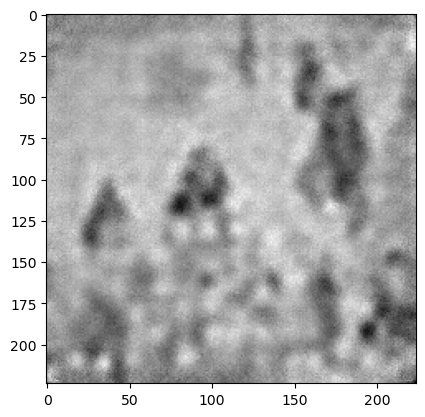

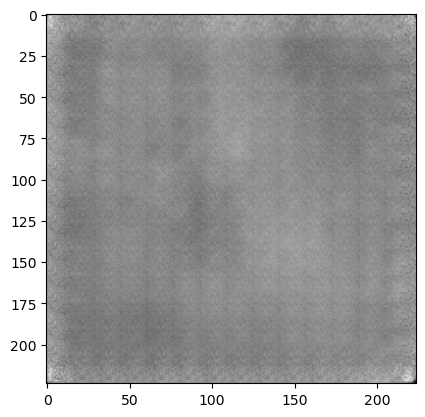

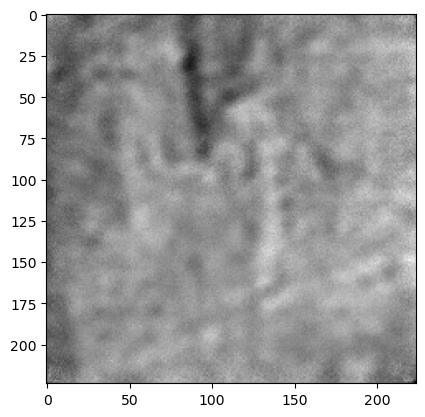

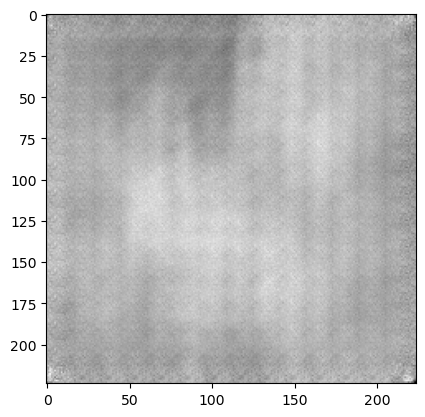

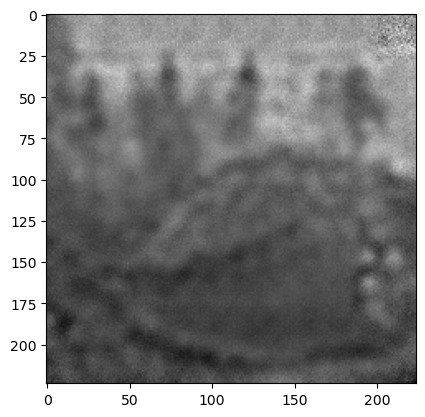

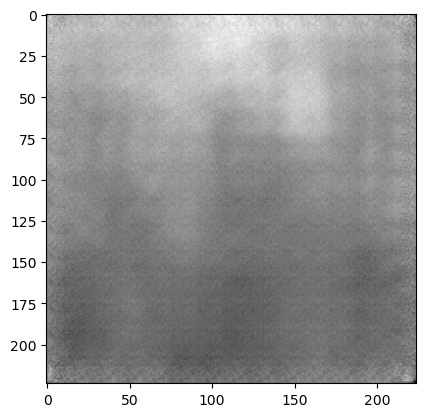

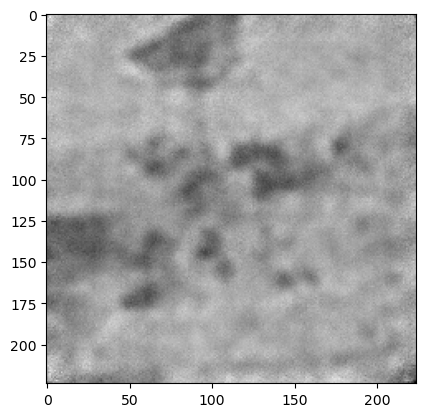

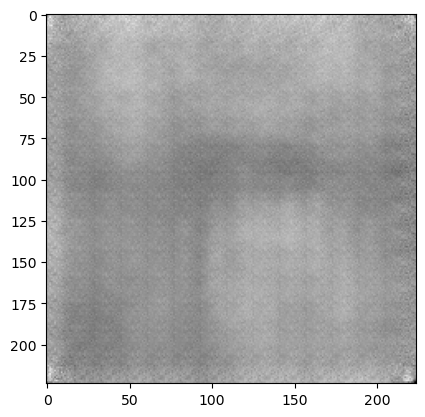

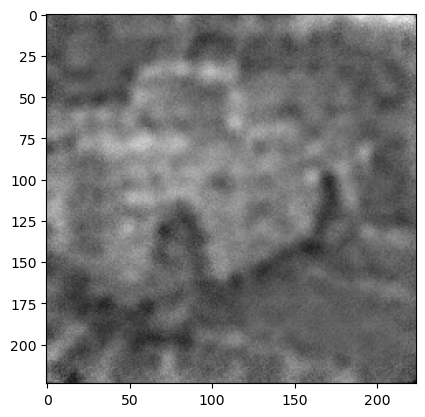

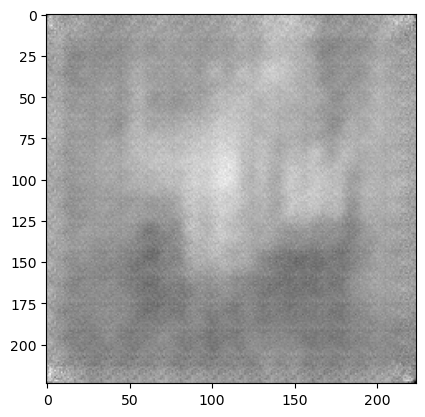

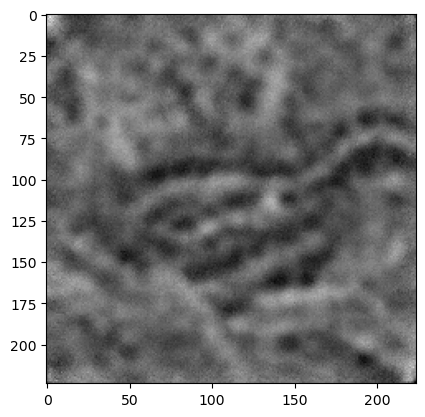

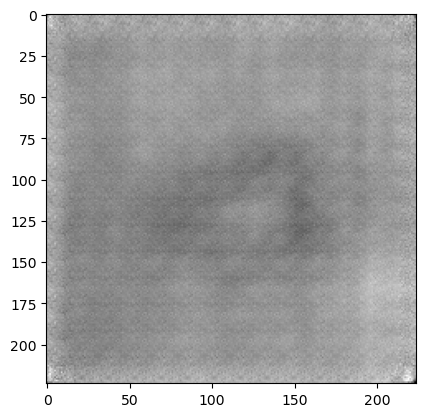

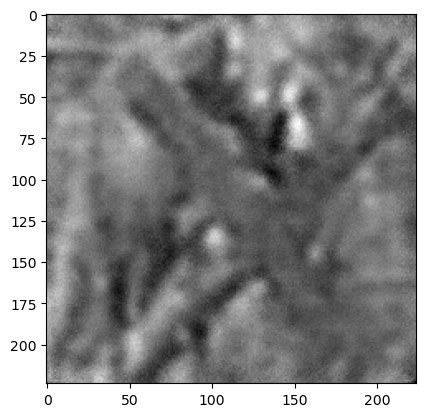

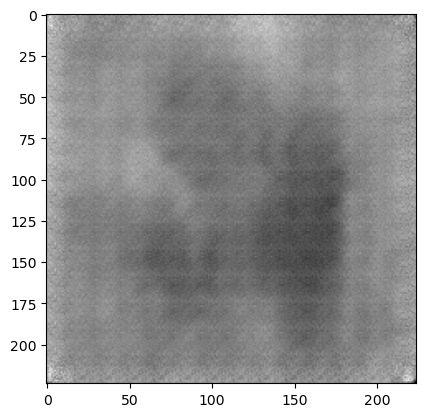

torch.Size([36, 224, 224])


<Figure size 640x480 with 0 Axes>

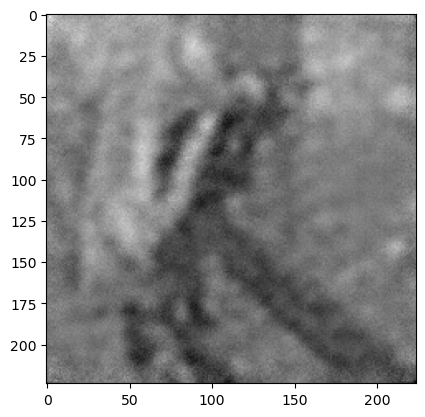

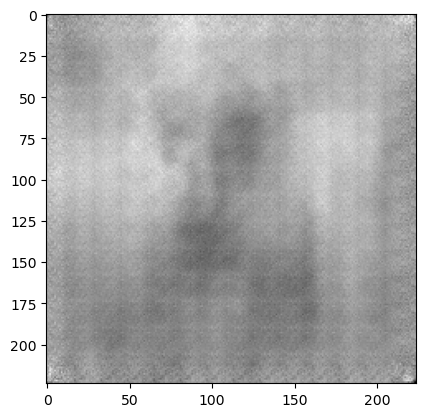

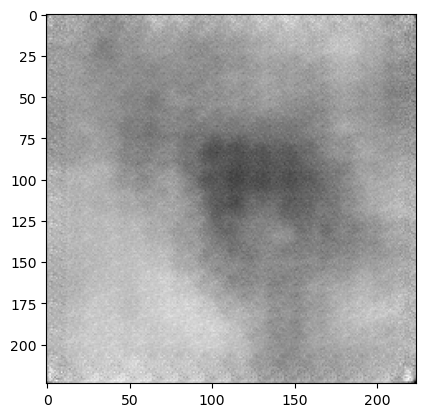

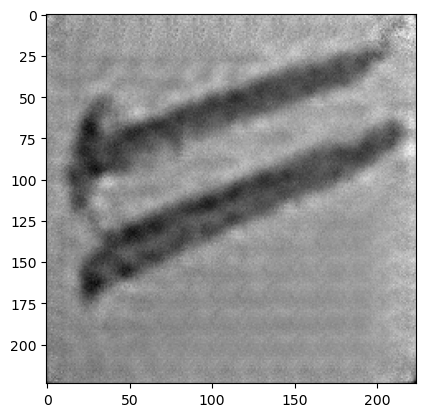

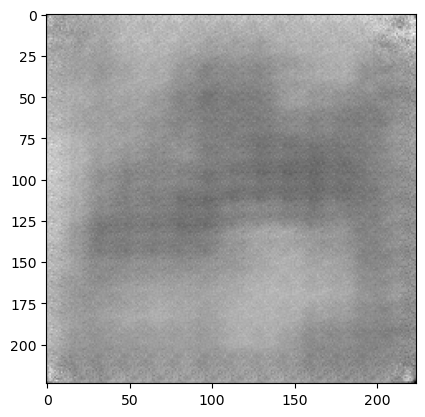

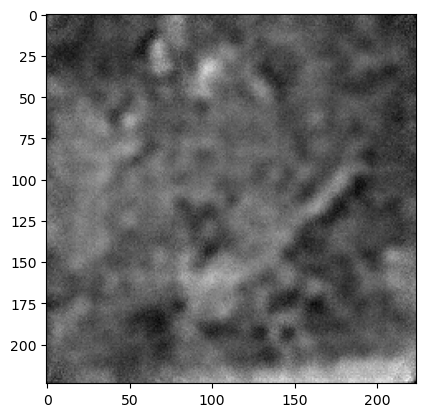

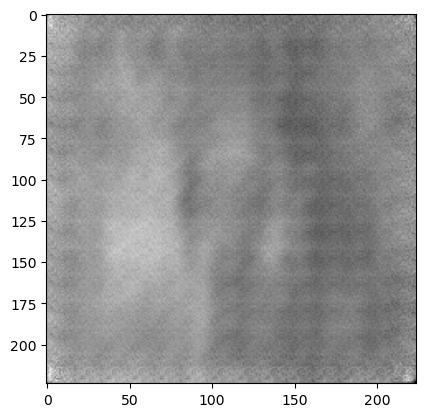

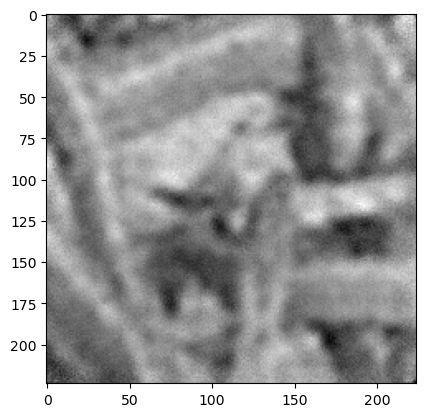

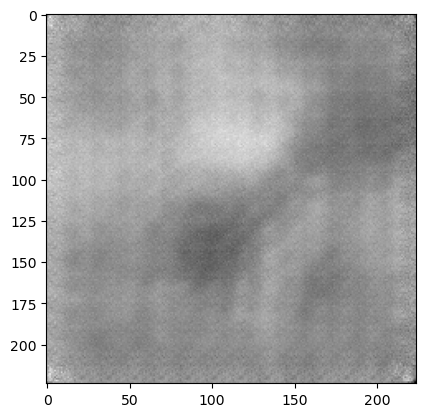

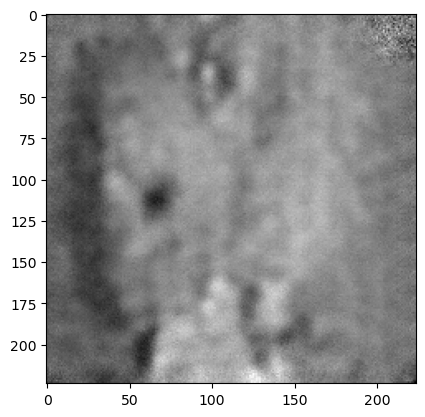

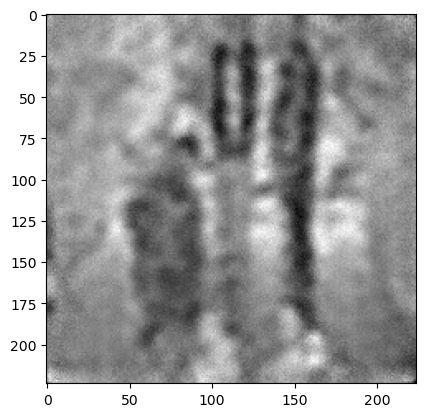

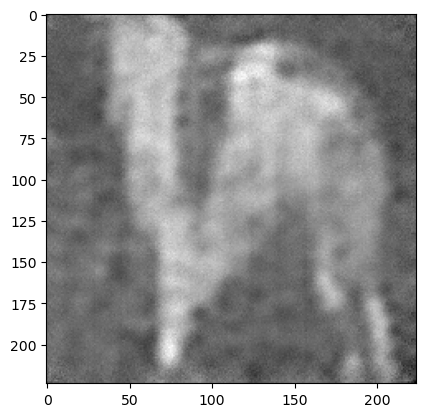

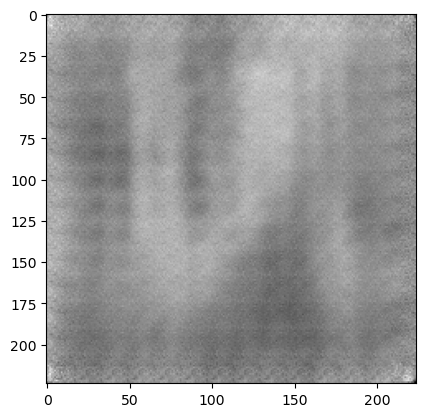

In [608]:

class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)
output_model = torch.load(RESNET_DECODE_MODEL)
output_model.eval()
for real, pred in zip(imgnet_activations_real, imgnet_activations_pred):
    plt.figure()
    with torch.no_grad():
        real_img = output_model(real.to('cuda', dtype=torch.float32).squeeze()).squeeze()
        print(real_img.shape)
        for i in range(1, 10):
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            pred_img = output_model(pred.to('cuda', dtype=torch.float32)).squeeze()
            plt.figure()
            plt.imshow(pred_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.show()